# Vertical, viscous deflection of a thin plate

The goal of this notebook is to treat an ice shelf as a rectangular thin plate, load it with some surface mass balance, and calculate the rate of vertical, viscous deflection. This notebook references a 2007 text by Dietrich Braess, [online lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf) by Jarkko Niiranen, and [MacAyeal et al., 2021](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3). I sketch the derivation of the weak form of the viscous deflection problem, solve the weak form using Firedrake, and verify that the solution preserves the original force balance constraint.

In [1]:
from firedrake import *
import matplotlib.pyplot as plt

# Deriving the variational form to be solved

## Strong form (force balance)

The stress balance for a thin plate states that the bending moment $\vec{M}$ relates to the load on the plate via

$$-\nabla\cdot\left(\nabla\cdot\vec{M}\right) = f(x, y).$$

This condition, when expanded out, is equivalent to Equation 46 in MacAyeal et al. Also see pg. 84 of Jarkko Niiranen's [lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf). In this context, $f(x, y)$ has units of stress (e.g., see Eq. 57 in MacAyeal et al.), and so the moment $\vec{M}$ has units of force (as in Eq. 18 of MacAyeal et al.). 


## Constitutive relation

The constitutive relation must relate $\vec{M}$ to the rate of vertical deflection, $\dot{\eta}$. I use the constitutive relation from MacAyeal et al. 2021 (Eq. 39), which states that, with $\overline{\nu}$ the depth-averaged effective viscosity associated with the flow field (which is independent of $\dot{\eta}$), 

$$\vec{M} = -\frac{\overline{\nu}H^3}{6}\left(\nabla^2\dot{\eta} + tr\left(\nabla^2\dot{\eta}\right)\vec{I}\right) + \rho_ig\frac{H^3}{12}\vec{I}.$$

In general, it will be necessary to obtain $\overline{\nu}$ via the velocity field. For now, we'll assume linear rheology, so that $\overline{\nu}$ is just a constant:

In [2]:
ν = 6e13 #representative uniform viscosity in Pascal-seconds

We can simplify this constitutive relation further by omitting the glaciostatic term (the final term on the right), as in MacAyeal et al. The second derivative of this term relates to convexity/concavity of the shelf, and it is expected to usually be small. In situations where this may not be the case, the glaciostatic term can be included in the load term defined later. Thus, for now, we use the constitutive relation:

$$\vec{M} = -\frac{\overline{\nu}H^3}{6}\left(\nabla^2\dot{\eta} + tr\left(\nabla^2\dot{\eta}\right)\vec{I}\right).$$




## Weak form

To obtain the weak form, multiply both sides of the governing equation by an arbitrary weight function $v(x, y)$, and integrate over the domain, so that

$$ -\int_{x, y}\nabla\cdot(\nabla\cdot\vec{M})v(x, y)dxdy = \int_{x, y}f(x, y)v(x, y)dxdy.$$

Integrate by parts twice, following pg. 93 of Jarkko Niiranen's [lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf), to find that

$$-\int_{x, y}\vec{M}:\nabla^2v(x, y)dxdy = \int_{x, y}f(x, y)v(x, y)dxdy,$$

where I have left out the boundary terms (since we'll just use the penalty method to include any desired boundary conditions anyway). Use the above constitutive relation, noting that $tr(\nabla^2\dot{\eta})\vec{I}:\nabla^2v = \Delta\dot{\eta}\Delta v$, to obtain the weak form of the problem:

$$\frac{1}{6}\int_{x, y}\overline{\nu}H^3\nabla^2\dot{\eta} : \nabla^2 vdxdy + \frac{1}{6}\int_{x, y}\overline{\nu}H^3\Delta\dot{\eta}\Delta v dxdy - \int_{x, y}f(x, y)v(x, y)dxdy = 0.$$

# Solving the problem with Firedrake

## Spatial extent and mesh

In [3]:
nx, ny = 100, 50
Lx, Ly = 10000, 5000 #10 km long by 5 km wide shelf
mesh = RectangleMesh(nx, ny, Lx, Ly)

x, y = SpatialCoordinate(mesh)
Q = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements of order 5 are needed to solve this 4th-order problem

## Physical parameters

In [4]:
ρ_i = 917 #ice density in kg/m^3
ρ_w = 1024 #saltwater density in kg/m^3
g = 9.81 #g in N/kg
H0 = 600 #initial shelf thickness in meters

## Trial and test functions, and their gradients

In [5]:
#trial function η and its gradients
η = Function(Q) #the deflection rate to be solved for
ddη = grad(grad(η)) #∇^2(η)
Δη = div(grad(η)) #the laplacian of η

#test function and its gradients
v = TestFunction(Q) 
ddv = grad(grad(v))
Δv = div(grad(v)) #the laplacian of v

## Load on the shelf

I'll load the shelf by imposing a spatially uniform surface mass balance, $\dot{B}\Delta t$, where $\dot{B}$ is the accumulation/ablation rate, and $\Delta t$ is some timestep. The load resulting from imposing this surface mass balance is a bit complex. For example, if $\dot{B}$ is negative, thickness is removed from the surface, resulting in a net buoyant force after $\Delta t$; the buoyant force results in an upward deflection which, in turn, will act to reduce the buoyant force causing the deflection. (A similar interaction occurs if $\dot{B}$ is positive.) Below, I derive the appropriate relationship between $\dot{B}$, $\dot{\eta}$ and the load $f$:

 - At time $t = 0$, the initial surface elevation is $s_0 = \left(1 - \frac{\rho_i}{\rho_w}\right)H_0$
 - After time $\Delta t$, the surface elevation becomes $s = \left(1 - \frac{\rho_i}{\rho_w}\right)H_0 + \dot{B}\Delta t + \dot{\eta}\Delta t$
 - Noting that deflections do not influence thickness, the updated thickness after $\Delta t$ becomes $H = H_0 + \dot{B}\Delta t$
 - Given the updated thickness, the equilibrium surface elevation would now be $s_{eq} = \left(1 - \frac{\rho_i}{\rho_w}\right)(H_0 + \dot{B}\Delta t)$
 - The height above/below buoyancy is $h_{ab} := s - s_{eq} = \frac{\rho_i}{\rho_w}\dot{B}\Delta t + \dot{\eta}\Delta t$
 - If $h_{ab} < 0$, the force on the shelf acts upward and attains value $f = -\rho_wgh_{ab}$
 - If $h_{ab} \geq 0$, the force on the shelf acts downward and attains value $f = -\rho_igh_{ab}$
 
 Therefore, the appropriate load on the shelf due to surface mass balance is given by:
 
 $$f = \begin{cases} -\rho_ig\dot{B}\Delta t - \rho_wg\dot{\eta}\Delta t & \frac{\rho_i}{\rho_w}\dot{B}\Delta t + \dot{\eta}\Delta t < 0\\
 -\frac{\rho_i^2}{\rho_w}g\dot{B}\Delta t - \rho_ig\dot{\eta}\Delta t & \frac{\rho_i}{\rho_w}\dot{B}\Delta t + \dot{\eta}\Delta t \geq 0
 \end{cases}$$

In [6]:
from icepack.constants import year as Δt #timestep will be the number of seconds in a year
B = -1/Δt #ablation/accumulation rate in meters per second
f = conditional(ρ_i/ρ_w*B*Δt + η*Δt < 0, -ρ_i*g*B*Δt - ρ_w*g*η*Δt, -ρ_i**2/ρ_w*g*B*Δt - ρ_i*g*η*Δt)

## Set up the problem to be solved

Solving the weak form is equivalent to minimizing the expression:

$$\Pi(\eta, v) = \frac{1}{6}\int_{x, y}\overline{\nu}H^3\nabla^2\eta : \nabla^2 vdxdy + \frac{1}{6}\int_{x, y}\overline{\nu}H^3\Delta\eta\Delta v dxdy + \int_{x, y}f(x, y)v(x, y)dxdy$$

subject to some boundary conditions. I'll impose no-slip boundary conditions at the sidewalls and the upstream boundary, so that $\eta = 0$ on boundaries 1, 3 and 4. Constraints will be enforced via the penalty method. 

In [7]:
L = 1/6*ν*H0**3*inner(ddη, ddv)*dx
L += 1/6*ν*H0**3*Δη*Δv*dx
L -= f*v*dx

######################################
######################################
### What value should I use for α? ###
######################################
######################################

α = 1e10
L += 0.5*α**2*(η*v)*ds(1)
L += 0.5*α**2*(η*v)*ds(3)
L += 0.5*α**2*(η*v)*ds(4)


## Solve and plot

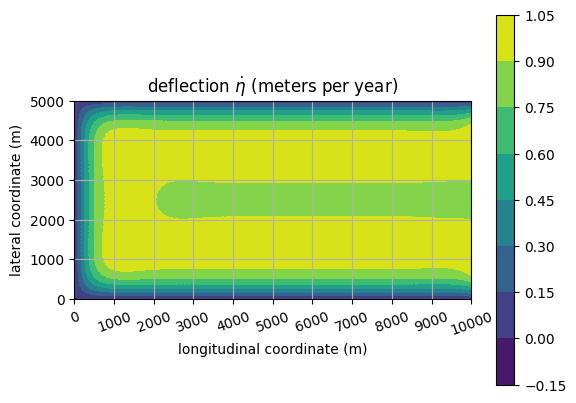

In [8]:
solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(project(η*Δt, Q), axes = ax)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('deflection $\dot{η}$ (meters per year)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Verify that the solution satisfies the force balance

If everything went right, we should have that $\nabla\cdot\left(\nabla\cdot\vec{M}(\eta)\right) + f(x, y) = 0$. As shown below, there is a fair bit of noise, but the noise does seem to get smaller and smaller as the mesh is refined, without significantly impacting the solution. 

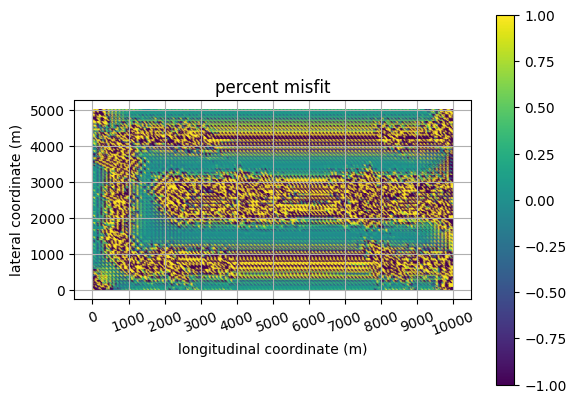

In [9]:
M = -ν*H0**3/6*(ddη + tr(ddη)*Identity(2))# + ρ_i*g*H0**3/12*Identity(2) #the tensor M, as obtained earlier
misfit = project((div(div(M)) + f)/f*100, Q) #should ideally be very small

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tripcolor(misfit, axes = ax, vmin = -1, vmax = 1)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation=20)
plt.title('percent misfit')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Update surface elevation

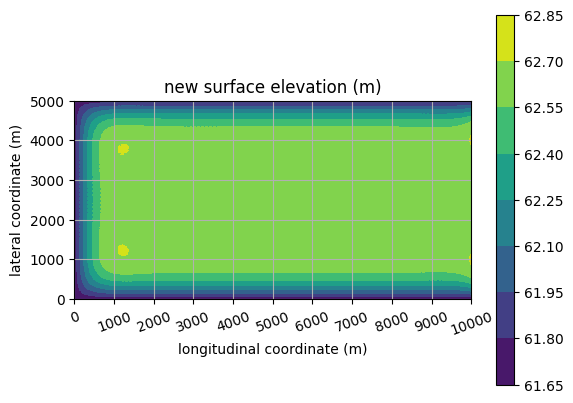

In [10]:
s = project((1 - ρ_i/ρ_w)*H0 + B*Δt + η*Δt, Q) #s = s0 + SMB + η
#hab = project(ρ_i/ρ_w*SMB + η, Q) #height above buoyancy

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(s, axes = ax)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation=20)
plt.title('new surface elevation (m)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Postprocessing

The deviatoric stress tensor, as a function of both the flow field and the deflection field, can be calculated from the deflection rate via Equation 14 of MacAyeal et al. Notice that, in the expression below, $\nu$ is not depth-averaged. In the present case, $\nu = \overline{\nu}$ is a constant anyway, but in general, it will be necessary to make some assumptions about how $\nu$ varies with depth.

$$\vec{\tau} = \nu\left(\nabla\vec{u} + \nabla\vec{u}^T\right) - 2\nu\zeta\nabla^2\dot{\eta}$$


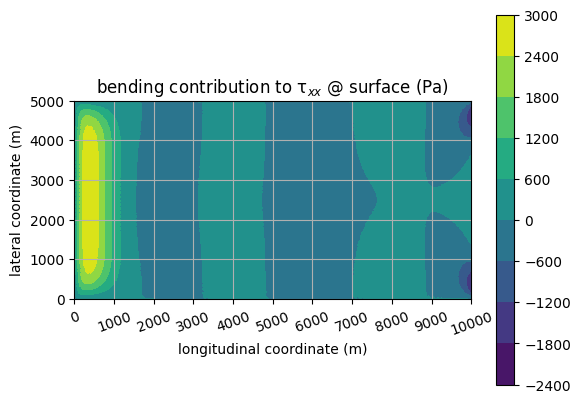

In [11]:
τ_surf_bending = -2*ν*H0/2*ddη #the bending part of τ evaluated at the surface of the plate
τxx = project(τ_surf_bending[0, 0], Q) #the bending part of τ_xx evaluated at the surface of the plate 

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(τxx, axes = ax)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('bending contribution to τ$_{xx}$ @ surface (Pa)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()